# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

In [5]:
len(df_users_train)

7199

Зачитываем категории пользователей

In [3]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [4]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users)
X = X_dataset[np.where(ix)]

In [5]:
X

<6847x272579 sparse matrix of type '<type 'numpy.float64'>'
	with 2217684 stored elements in Compressed Sparse Row format>

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [5]:
Y = df_users_train['cls'].values[np.where(ix)]
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (6847x272579) feature matrix, 6847 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

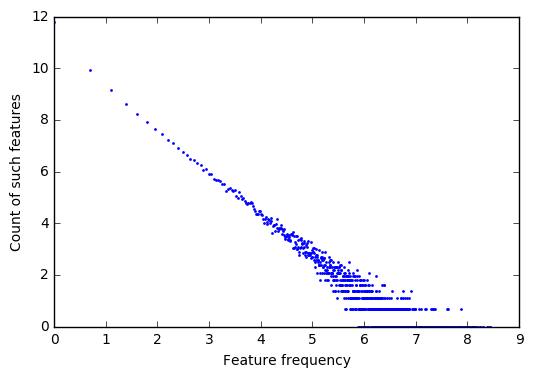

In [119]:
import collections
from pylab import scatter
import pylab
import matplotlib.pyplot as plt

buckets = collections.defaultdict(int)

    
def draw_log_hist(X):
    """Draw tokens histogram in log scales"""
    features_counts = np.zeros(X.shape[1], dtype=np.int32)
    Xc = X.tocsc()

    for feature_idx in xrange(X.shape[1]):
        frequency = Xc[:,feature_idx].size
        features_counts[feature_idx] = frequency
        buckets[frequency] += 1
    
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(np.log(buckets.keys()), np.log(buckets.values()), 'o', markeredgecolor='none', markersize=2)
    plt.xlabel('Feature frequency')
    plt.ylabel('Count of such features')
    pylab.show()
    
    return features_counts

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [7]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

In [70]:
X2 = X.tocsc()[:, features_counts > 700].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [8]:
USER_NAME = "v.matveeva"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [116]:
from scipy.sparse import csr_matrix, csc_matrix
def sigmoid(z):
    return 1 / (1 + exp(-z))

class LogisticRegression():
    
    def __init__(self, C1 = 1.0, eps =  0.01, max_iter = 15):
        self.C1 = C1
        self.max_iter = max_iter
        self.eps = eps
    

    def compute_cost(self, X, y, theta):
        N = len(y)
        y = np.array(y)
        res = np.array(map(sigmoid, np.dot(X, theta.T)))
        J = (1./N) * (np.dot(-transpose(y), (log(res))) - np.dot(transpose(1 - y), (log(1 - res))))
        return J + self.C1 * np.sum(theta ** 2)

    def cost_function_gradient (self, X, y, theta):
        N = len(y)
        y = np.array(y)
        theta = np.array(theta)
        res = np.array(map(sigmoid, np.dot(X, theta.T))) - y
        gradient = np.dot(res , X) / N
        return gradient + 2 * self.C1 * np.sum(theta)
    
    def cost_function_hessian (self, X, y, theta):
        N = len(y)
        sig = np.array(map(sigmoid, np.dot(X, theta.T)))
        res = sig * (np.ones(N) - sig)
        matrix_sum = csc_matrix(np.zeros((theta.shape[0], theta.shape[0])))
        for i in xrange(N):
            matrix_sum += (csr_matrix([X[i]]).T).dot(csr_matrix([X[i]])) * res[i]
        summ = matrix_sum / N
        return summ.toarray() + 2 * self.C1 * theta.shape[0]
    
    
    def fit(self, X, y=None):
        theta = np.ones(X.shape[1])
        self.theta = np.zeros(X.shape[1])
        i = 0
        while dist(theta, self.theta) > self.eps and i < self.max_iter:
            i += 1
            #print i
            theta = self.theta
            grad = self.cost_function_gradient(X, y, theta)
            Hessian = self.cost_function_hessian(X, y, theta)
            #H = Hessian
            delta = np.linalg.solve(Hessian, grad)
            self.theta = theta - delta
        return self
    
    def predict_proba(self, X):
        return sigmoid(np.dot(X, self.theta))

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [114]:
def auroc(y_prob, y_true):
    y_prob_sort = []
    for i, x in enumerate(y_prob):
        y_prob_sort.append((i, x))
    y_prob_sort.sort(key=lambda item: item[1], reverse = True)
    #print y_prob_sort
    N = len(y_prob)
    steps_up = [0]
    steps_right = [0]
    s = 0.0
    y_curr = 0
    j = 1
    for i, x in y_prob_sort:
        y_curr = y_true[i]
        if y_curr == 1:
            steps_up.append(steps_up[j-1] + 1)
            steps_right.append(steps_right[j-1])
        else:
            steps_right.append(steps_right[j-1] + 1)
            steps_up.append(steps_up[j-1])
        j += 1
    for i in xrange(N - 1):
        for j in xrange(i + 1, N):
            yi = y_true[y_prob_sort[i][0]]
            yj = y_true[y_prob_sort[j][0]]
            if yi < yj:
                s += 1
    steps_up = np.array(steps_up)
    steps_right = np.array(steps_right)
    lpos = 1.0 * len(y_true[y_true == 1])
    #print lpos
    lneg = 1.0 * len(y_true[y_true == 0])
    #print lneg
    return steps_up/lpos, steps_right/lneg, s / (lpos * lneg)

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [117]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]
SIZE = 1000
auc_scores = dict()
def CrossValidation(X, Y, size, cross_val_id):    
    ind = [idx >= size * cross_val_id and idx < size * (cross_val_id + 1) for idx in range(X.shape[0])]
    array_ind = np.array(ind)
    not_ind_array = np.logical_not(array_ind)
    X_1 = X[np.where(array_ind)]
    X_2 = X[np.where(not_ind_array)]
    Y_1 = Y[np.where(array_ind)]
    Y_2 = Y[np.where(not_ind_array)]
    #print Y_1
    return (X_1, Y_1, X_2, Y_2)

def select_reg_parameter(C, X, Y):
    
    selected_index = 0
    best_auc_score = 0.0
    for i in xrange(len(C)):
        C_value = C[i]
        if (X.shape[0] % SIZE > 0):
            pieces = X.shape[0] / SIZE + 1  
        else: pieces = 0
        print 'pieces ', pieces 
        local_auc_score = 0.0
        model = LogisticRegression(C1 = C_value)
        #converges = False
        for j in xrange(pieces):
            X_1, Y_2, X_trn, Y_trn = CrossValidation(X, Y, SIZE, j)
            model.fit(X_trn, Y_trn)
            Y_3 = model.predict_proba(X_1)
            local_auc_score = local_auc_score + auroc(Y_3, Y_2)[2]
        if pieces != 0:
            local_auc_score = local_auc_score / pieces
        auc_scores[i] = local_auc_score
        print 'score', local_auc_score
        
        if local_auc_score > best_auc_score:
            selected_index = i
            best_auc_score = local_auc_score
            
    return selected_index

index = select_reg_parameter(C, X2, Y)
print index


pieces  7
score 0.494386859001
pieces  7
score 0.495028530839
pieces  7
score 0.495029443969
pieces  7
score 0.495029777602
pieces  7


KeyboardInterrupt: 

Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

1
2
3
4
5
6
7
CPU times: user 3min 26s, sys: 25.4 s, total: 3min 51s
Wall time: 3min 52s
Area under the ROC curve : 0.492087


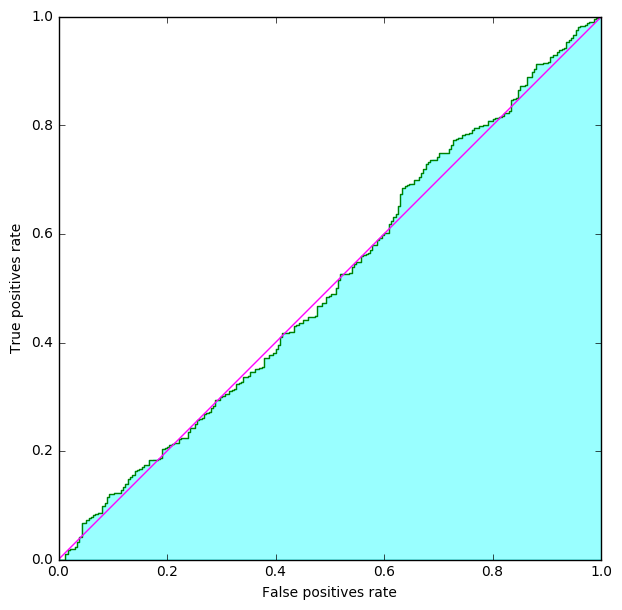

In [115]:
def classify(X, Y, test_size, C):
    #tpr = [1] * 2400
    #fpr = [0.01] * 2400
    #roc_auc = 0.51
    model = LogisticRegression(C1 = C)
    X_1, Y_2, X_trn, Y_trn = CrossValidation(X, Y, test_size, 1)
    model.fit(X_trn, Y_trn)
    Y_3 = model.predict_proba(X_1)
    tpr, fpr, roc_auc = auroc(Y_3, Y_2)

    return tpr, fpr, roc_auc

%time tpr, fpr, roc_auc = classify(X2, Y, 1000, 1.0)

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    
    # Your code here
    fig = plt.figure(figsize=(7, 7))
    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.plot(fpr, tpr, color='green')
    plt.plot([0, 1], [0, 1], color='magenta')
    pl.fill_between(fpr, tpr, alpha=0.4, color='cyan')
    plt.xlabel("False positives rate")
    plt.ylabel("True positives rate")
    plt.show()
    
    return

plot_roc_curve(list(tpr), list(fpr), roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.